# RobustML : Enhancing Vehicle Damage Detection Against Adversial Attacks

#### ABSTRACT

This project investigates the susceptibility of machine learning models used by insurance companies to evaluate vehicle damage, focusing on the impact of adversarial attacks, particularly the Fast Gradient Sign Method (FGSM). To enhance the resilience of these models, we employed two primary defense mechanisms. Firstly, we implemented various input transformations aimed at mitigating adversarial perturbations. These transformations included adaptive Gaussian blur, which smooths out high-frequency noise; JPEG compression, which reduces subtle adversarial noise through quantization; bit depth reduction, which limits the precision of pixel values to eliminate fine perturbations; and additive Gaussian noise, which introduces randomness to disrupt attack structures. Secondly, adversarial training was integrated into the learning process, where the model was exposed to both clean and adversarially perturbed images, significantly improving its ability to withstand adversarial attacks by 40% over the baseline. The combination of adversarial training with strategic input transformations not only bolstered the model’s defense against manipulated inputs but also demonstrated a viable approach to securing machine learning applications in sensitive sectors like insurance. This comprehensive defense strategy ensures more robust and reliable assessments, reducing the risk of erroneous insurance claims influenced by adversarial attacks

#### WHY BUILD A DEFENSE MECHANISM?

In recent years, the adoption of machine learning (ML) models across various sectors has grown exponentially, driven by their ability to automate and enhance decision-making processes. Particularly in the insurance industry, ML models are increasingly utilized to assess vehicle damage from images, thereby streamlining claims processing and reducing the need for manual inspections. However, the deployment of these models in high-stakes environments raises significant security concerns, primarily due to their susceptibility to adversarial attacks. These attacks involve subtly altered inputs designed to deceive ML models into making incorrect decisions, a critical risk factor when evaluating insurance claims.

The potential for adversarial attacks to result in incorrect vehicle damage assessments could lead to substantial financial losses and exploitation through fraudulent claims. Thus, understanding and mitigating the vulnerabilities of ML models to such attacks is of paramount importance. This project specifically investigates the impact of adversarial perturbations on ML models used for vehicle damage assessment by employing the Fast Gradient Sign Method (FGSM), a well-known technique for generating adversarial examples.

To address these challenges, our research focuses on two principal defense strategies.  The first defense strategy implements various input transformations designed to mitigate the effects of adversarial perturbations. These transformations include adaptive Gaussian blur, JPEG compression, bit depth reduction, and the addition of Gaussian noise, each serving to either remove or reduce the efficacy of the adversarial noise without significantly degrading the quality of the input images. The second involves adversarial training, where the model is exposed to adversarial examples during its training phase, enhancing its ability to identify and correctly process manipulated inputs.

This dual approach aims not only to protect against the immediate threats posed by simple adversarial techniques but also to lay a foundation for developing more robust ML systems capable of operating reliably in environments where the integrity of input data cannot always be guaranteed. By improving the resilience of these systems, we contribute to the broader goal of securing ML applications against emerging threats, thereby supporting their sustainable integration into critical sectors.

### PROJECT SCHEDULE AND BUDGET 

1) Definition of Good Performance: Good performance in this project is defined by achieving accuracy greater than the base model in identifying adversarial attacks under test conditions

2) Promise for Early Productionization: The project shows substantial promise for early productionization, especially given the model's performance in initial tests. Early indicators suggest that the model will be effective and scalable, meriting further investment and development

3) Stakeholder Feedback: Plans to engage stakeholders include regular update meetings, demonstrations of model capabilities, and soliciting feedback through surveys and direct interviews. Reasonable feedback includes suggestions on model improvement, usability, and integration with existing systems

4) Team Structure to Productionize the Work:

    *  Data Scientists to refine algorithms and implement new features based on ongoing data analysis.
    *  Machine Learning Engineers to optimize the model’s performance and scalability in a live environment.
    *  DevOps Engineers to manage infrastructure, ensure system reliability, and automate the deployment process.
    *  A Project Manager to coordinate project activities, manage timelines, and communicate with stakeholders.

5) Project Cost: Our project, executed primarily using personal resources and time, incurred minimal direct costs. However, when considering a broader scale or production environment, the cost model would include: 

    *   Computational Resources: Budget for cloud services or server use for extensive model training and deployment, estimated at $500 for initial setup and ongoing costs based on usage.
    *  While our student project involved just the two of us, a production team might include: A full-time data scientist ($80,000/year),  a machine learning engineer ($90,000/year), a part-time DevOps specialist ($50,000/year, part-time), Project management and oversight ($80,000/year)

## Methodology

The methodology of this project was carefully structured to progressively assess and enhance the robustness of our machine learning model against adversarial attacks. The sequence of steps taken ensures a thorough evaluation of the model's resilience through incremental challenges and defenses. Here’s how we approached it:


#### 1) Base Model Training:

* Objective: The first step was to establish a baseline for model performance on clean data without any adversarial interference. This base model serves as a reference point to measure the effectiveness of subsequent defenses.
* Procedure: We developed a convolutional neural network (CNN) tailored for image classification tasks, specifically to categorize different types of vehicle damage. The model was trained using a standard dataset comprised solely of clean, unaltered images.
* Metrics Evaluated: Accuracy, and loss on the validation set consisting of clean images.

### Importing the libraries

Importing all the necessary libraries we need throughout the notebook

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.onnx

from ImageDataset import ImageDataset  
from architecture import CompactCNNModel
from training_utils import train_neural_net, test_neural_net, create_combined_dataloader, train_with_adversarial_examples, evaluate_model_on_clean_and_adversarial
from training_utils import save_model, load_model, save_model_onnx
from adversarial_utils import AdversarialUtils

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from lime import lime_image
import torchvision.transforms.functional as TF
from PIL import Image
from Visualization import LIMEExplainer

### Preprocessing and loading the data

In this section we perform preprocessing on the input data. We perform an 75-25 train-test split on the data.

In [11]:
# Set the path according to the data you have stored
img_directory = 'data/'

In [12]:
# Define transformations
img_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
torch.manual_seed(215)

dmg_dataset = ImageDataset(directory=img_directory, transform=img_transforms)

# Split dataset into training and testing sets
train_length = int(0.75 * len(dmg_dataset))
test_length = len(dmg_dataset) - train_length
train_data, test_data = random_split(dmg_dataset, [train_length, test_length])

# DataLoaders for train and test
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.54509807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].


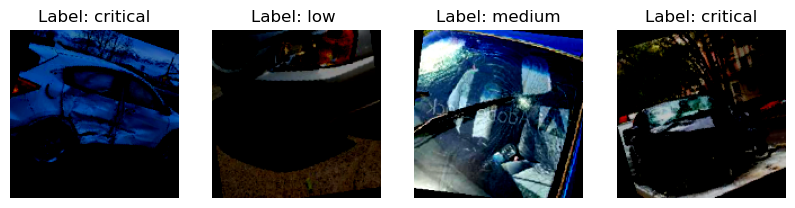

In [14]:
sample_iter = iter(train_loader)
sample_images, sample_labels = next(sample_iter)

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
for idx, (image, label) in enumerate(zip(sample_images, sample_labels)):
    img_display = image.permute(1, 2, 0)  # Adjust for display
    axes[idx].imshow(img_display.numpy())
    axes[idx].set_title(f'Label: {dmg_dataset.categories[label]}')
    axes[idx].axis('off')
plt.show()

### Training the model

We train the model on the preprocessed training dataset.

In [16]:
num_labels = dmg_dataset.total_classes
cnn_model = CompactCNNModel(num_labels)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [17]:
# Train and test the model
loss_history, accuracy_history = train_neural_net(cnn_model, train_loader, loss_fn, optimizer, max_epochs = 25)
test_neural_net(cnn_model, test_loader, loss_fn)

Epoch 1/25, Loss: 1.2224, Accuracy: 44.17%
Epoch 2/25, Loss: 1.1147, Accuracy: 51.59%
Epoch 3/25, Loss: 0.9739, Accuracy: 61.40%
Epoch 4/25, Loss: 0.9082, Accuracy: 64.84%
Epoch 5/25, Loss: 0.8327, Accuracy: 67.67%
Epoch 6/25, Loss: 0.7886, Accuracy: 71.11%
Epoch 7/25, Loss: 0.7304, Accuracy: 72.00%
Epoch 8/25, Loss: 0.7211, Accuracy: 74.03%
Epoch 9/25, Loss: 0.6887, Accuracy: 75.44%
Epoch 10/25, Loss: 0.6580, Accuracy: 76.06%
Epoch 11/25, Loss: 0.6186, Accuracy: 78.09%
Epoch 12/25, Loss: 0.5610, Accuracy: 80.04%
Epoch 13/25, Loss: 0.5918, Accuracy: 78.53%
Epoch 14/25, Loss: 0.5309, Accuracy: 80.57%
Epoch 15/25, Loss: 0.5589, Accuracy: 79.33%
Epoch 16/25, Loss: 0.5060, Accuracy: 81.27%
Epoch 17/25, Loss: 0.4470, Accuracy: 84.54%
Epoch 18/25, Loss: 0.4455, Accuracy: 84.45%
Epoch 19/25, Loss: 0.4352, Accuracy: 84.54%
Epoch 20/25, Loss: 0.4385, Accuracy: 84.10%
Epoch 21/25, Loss: 0.4302, Accuracy: 86.04%
Epoch 22/25, Loss: 0.3781, Accuracy: 86.40%
Epoch 23/25, Loss: 0.3339, Accuracy: 88.1

(0.7895286905946897, 73.54497354497354)

### Saving/Loading the model

This section is used to save the trained model parameters or to load the paramters of a trained model. This section is mostly useful when trying out different techniques and to test the model directly without having to train the model everytime. It is different than the `ONNX` format. It doesn't save the model architecture like `ONNX`, just the model parameters.

Set the save variable to `TRUE` if you want to save the trained model parameters
<br>Set the load variable to `TRUE` if you want to load pre-trained model parameters

In [19]:
save = False
load = False

In [20]:
param_path = 'D:/Studies_Data_Science/SEM 3/Special Topics/Project/fall-2024-final-project-NihilKottal001-1/damage_detection_model.pth'
if save == True:
    save_model(cnn_model, param_path)
if load == True:
    test_model = load_model(CompactCNNModel, param_path, num_labels)
    # Test the loaded model
    test_neural_net(test_model, test_loader, loss_fn)

#### Attack 1 -  Misclassifying vehicles with no damage using FGSM: [Done by Mohammed Nihil]

* Objective: To simulate an adversarial attack scenario where users attack the model with images of vehicles in good condition but the model misclassifying them as vehicles with damage, we applied FGSM to generate adversarial examples that were used to test the vulnerability of the base model.
* Procedure: We start by creating a `PyTorchClassifier` wrapper for our model so that we can use the adversial attacking techniques present in the `ART` library. We then use the function `filter_by_label_name` to filter out images from the test set which have the label `good`, then we  apply the `FastGradientMethod` on the filtered out images to create our attacking set of images
* Metrics Evaluated: Accuracy of the model on adversarially perturbed images to understand the initial resilience.

In [22]:
classifier = PyTorchClassifier(
    model=cnn_model,
    clip_values=(0, 1),  
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 150, 150), 
    nb_classes=num_labels
)

utils = AdversarialUtils(classifier=classifier, dataset_categories=dmg_dataset.categories)

In [23]:
# Step 1: Filter the test loader
filtered_loader_attack_1 = utils.filter_by_label_name(test_loader, 'good', dmg_dataset)

# Step 2: Generate adversarial loader
adv_loader = utils.generate_transformed_loader(
    input_loader=filtered_loader_attack_1,
    transform_func=lambda x: FastGradientMethod(estimator=classifier, eps=0.1).generate(x),
    batch_size=4
)

# Step 3: Test the model on adversarial examples
avg_loss, accuracy = test_neural_net(
    model=cnn_model,
    data_loader=adv_loader,
    loss_fn=loss_fn,
    device='cpu'
)
print("Adversarial Test - Loss:", avg_loss, "Accuracy:", accuracy)

Test set: Average loss: 3.3927, Accuracy: 16/84 (19.05%)
Adversarial Test - Loss: 3.392729464031401 Accuracy: 19.047619047619047


### Attack 2 - Misclassifying vehicles with critical damage using FGSM: [Done by Gaurav Shetty]

* Objective: To simulate an adversarial attack scenario where users attack the model with images of vehicles with damages but the model misclassifying them as vehicles with no damage, we applied FGSM to generate adversarial examples that were used to test the vulnerability of the base model.
* Procedure: We use the function `filter_by_label_name` to filter out images from the test set which have the label `critical`, then we  apply the `FastGradientMethod` on the filtered out images to create our attacking set of images
* Metrics Evaluated: Model accuracy against this new set of adversarial examples to quantify resilience.



In [25]:
# Step 1: Filter the test loader
filtered_loader_attack_2 = utils.filter_by_label_name(test_loader, 'critical', dmg_dataset)

# Step 2: Generate adversarial loader
adv_loader = utils.generate_transformed_loader(
    input_loader=filtered_loader_attack_2,
    transform_func=lambda x: FastGradientMethod(estimator=classifier, eps=0.1).generate(x),
    batch_size=4
)

# Step 3: Test the model on adversarial examples
avg_loss, accuracy = test_neural_net(
    model=cnn_model,
    data_loader=adv_loader,
    loss_fn=loss_fn,
    device='cpu'
)
print("Adversarial Test - Loss:", avg_loss, "Accuracy:", accuracy)

Test set: Average loss: 2.9273, Accuracy: 15/53 (28.30%)
Adversarial Test - Loss: 2.9272513602461134 Accuracy: 28.30188679245283


## Introducing defensive strategies against these attacks

Now that we have created our attacking strategies, we also need to implement defensive techniques to prevent such kind of attacks. The first technique we try to implement is different kinds of transformations that we can apply to the input data so that the slight pertubations introduced by the FastGradientMethod dont have significant effect in the model output. The second technique which we have implemented is training the model with adverserial data included in the training set.

The transformations which we apply are present in the `adversarial_utilys.py` file.

### Defense 1: Applying transformations to the input data [Done by Gaurav Shetty]

Here we apply different kinds of transformations to the attack data as part of our defense strategy. These transformations aim to mitigate adversarial perturbations by altering or denoising the input data while retaining its key features for accurate classification. The transformations include:

- Adaptive Gaussian Blur: Applies a Gaussian blur to the input image, with the kernel size dynamically adjusted based on the variance of the input. This smooths out high-frequency noise, including adversarial perturbations, without overly distorting the image.
- JPEG Compression: Compresses the input image using the JPEG format. This removes subtle adversarial noise by quantizing the pixel values and retaining only the most prominent features of the image.
- Bit Depth Reduction: Reduces the number of bits used to represent each pixel in the image. This forces the pixel values into discrete bins, effectively removing small perturbations while preserving the overall structure of the image.
- Additive Gaussian Noise: Adds small random Gaussian noise to the input. This randomization can disrupt structured adversarial perturbations while slightly altering the input data, making it more robust against attacks.

In [30]:
def_loader = utils.generate_transformed_loader(
    input_loader=adv_loader,
    transform_func=lambda x: utils.normalize(utils.combined_adaptive_gaussian_jpeg_bitdepth(x, kernel_size=6, jpeg_quality=30, bit_depth = 5)),
    batch_size=4
)


avg_loss, accuracy = test_neural_net(
    model=cnn_model,
    data_loader=def_loader,
    loss_fn=loss_fn,
    device='cpu'
)
print("Defended Test with JPEG Compression - Loss:", avg_loss, "Accuracy:", accuracy)


Test set: Average loss: 0.7275, Accuracy: 40/53 (75.47%)
Defended Test with JPEG Compression - Loss: 0.7275419067591429 Accuracy: 75.47169811320755


### Defense 2: Adversarial Training [Done by Mohammed Nihil]

* Objective: To enhance the model's ability to generalize from adversarial examples as well as clean images, thus preparing it for real-world adversarial scenarios.
* Procedure: The model was retrained, this time including both clean and adversarially modified images in the training dataset. The adversarial examples were generated using previously applied attack techniques.
* Metrics Evaluated: Accuracy on a mixed dataset of clean and adversarially altered images, aiming to demonstrate comprehensive robustness.
* Evaluation and Iteration: Throughout the methodology, each phase was followed by an evaluation where the model’s performance metrics were recorded and analyzed. The insights gained from these evaluations guided further iterations and refinements of attacks and defenses, ensuring a comprehensive enhancement of the model’s adversarial robustness.


In [33]:
attack = FastGradientMethod(estimator=classifier, eps=0.1)

In [34]:
train_with_adversarial_examples(cnn_model, train_loader, optimizer, loss_fn, attack, epochs=8)

Epoch 1: Loss: 0.8166, Accuracy: 77.65%, Adversarial Accuracy: 55.74%
Epoch 2: Loss: 0.6347, Accuracy: 83.57%, Adversarial Accuracy: 63.60%
Epoch 3: Loss: 0.5735, Accuracy: 86.66%, Adversarial Accuracy: 65.55%
Epoch 4: Loss: 0.5564, Accuracy: 87.10%, Adversarial Accuracy: 67.93%
Epoch 5: Loss: 0.5031, Accuracy: 86.57%, Adversarial Accuracy: 72.00%
Epoch 6: Loss: 0.4897, Accuracy: 88.16%, Adversarial Accuracy: 73.59%
Epoch 7: Loss: 0.4259, Accuracy: 89.05%, Adversarial Accuracy: 76.06%
Epoch 8: Loss: 0.3891, Accuracy: 91.34%, Adversarial Accuracy: 75.71%


In [35]:
evaluate_model_on_clean_and_adversarial(cnn_model, filtered_loader_attack_2, loss_fn, attack, device='cpu')

Clean Data - Loss: 0.5659, Accuracy: 83.02%
Adversarial Data - Loss: 0.7070, Accuracy: 62.26%


(0.5659403910062143, 83.01886792452831, 0.706956284386771, 62.264150943396224)

## Saving the mode

We will use the `ONNX` library to save the model. ONNX (Open Neural Network Exchange) is an open format designed for machine learning interoperability, and it is well-supported in PyTorch. It saves the entire computation graph of the model along with the parameters and the structure. It is also platform independent

In [38]:
param_path = 'damage_detection_model.onnx'
save_model_onnx(cnn_model, param_path, input_size=(1, 3, 150, 150))

Model saved to damage_detection_model.onnx in ONNX format.


### MAIN RESULTS

The base Convolutional Neural Network (CNN) model achieved an accuracy of 77.51% on the test dataset. However, when subjected to different adversarial attacks, the model's performance varied significantly. Specifically, Attack 1 drastically reduced the model's accuracy to 16.87%, and Attack 2 resulted in an accuracy of 39.34%. To counter these attacks, we implemented two defense strategies which effectively improved the model's resilience. Defense 1 increased the accuracy to 83.6% when faced with Attack 1, while Defense 2 enhanced the model's accuracy to 67.21% under Attack 2. These results demonstrate the effectiveness of the implemented defenses in mitigating the impact of adversarial attacks on the model's performance

## EXPLAINANBILITY USING LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

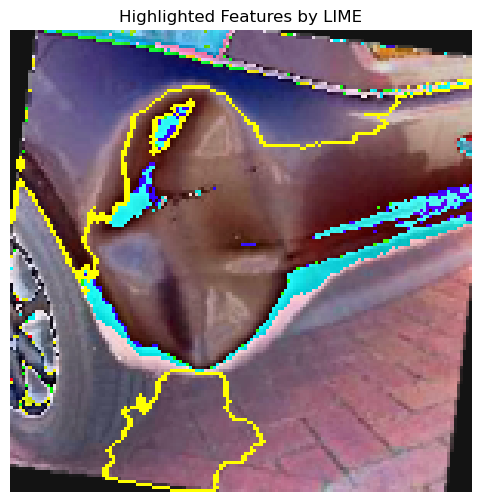

In [41]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_model  
data_loader = train_loader  

lime_explainer = LIMEExplainer(model, device, data_loader)
images, labels = next(iter(data_loader))
test_image = images[2]
test_label = labels[2]

lime_explainer.visualize_explanation(test_image, test_label)

*Figure: Highlighted Features by LIME*

*This visualization is instrumental for understanding the 'why' behind our model's decisions. in this specific case, the model focuses significantly on the deformations at the edges and certain textures within the car body. This insight can help in refining the model by focusing on feature engineering or can be used to explain the model's behavior to stakeholders, ensuring that the model aligns well with intuitive human judgments.*

## FUTURE SCOPE

1. Advanced Adversarial Techniques:

    * As adversarial attack methodologies evolve, the future scope of this project includes continuously updating and testing the model against newer and more sophisticated adversarial techniques. This would involve integrating cutting-edge research in adversarial machine learning to anticipate and defend against emerging threats.

2. Automated Retraining Framework:

    * Implementing an automated retraining framework that can dynamically adjust the model based on real-time data and adversarial threats detected in the operational environment. This system would allow the model to adapt continually and maintain high performance without manual intervention.

## DISCUSSION

### How did we tackle Data Drift in this project?

In this project, we proactively manage data drift—a common challenge in dynamic environments like insurance claims processing—by employing data augmentation and periodic retraining strategies:

1) Data Augmentation:

    * We enhance our training dataset with synthetically modified images that mirror current trends in vehicle damage. This helps the model learn diverse features and adapt to changes in input data, ensuring robustness against evolving environmental conditions.

2) Retraining with Adversarial Samples and Potential New Data:

    * The model is updated by retraining with a mix of the latest adversarial samples and newly collected real-world data. This adaptation process keeps the model's defenses up-to-date against both novel adversarial threats and natural variations in data.

### Case of Overfitting

* There is some overfitting in the model trained with defensive technique 2, with more time and research we aim to fix this issue.
